<a href="https://colab.research.google.com/github/JasonRen003/NASAICESat-2/blob/main/ICESat_2White_Sands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
import os
import h5py
import datetime
import numpy as np
import matplotlib.pyplot as plt
!pip install basemap
!pip install basemap-data
from mpl_toolkits.basemap import Basemap
from scipy.optimize import curve_fit
import math
import matplotlib.ticker as ticker
from google.colab import files
import statistics
import io

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
ERROR: File "setup.py" not found for legacy project https://github.com/matplotlib/basemap/archive/master.zip.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: h

In [32]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))



Saving ATL08_20211224025509_00281406_005_01.h5 to ATL08_20211224025509_00281406_005_01.h5
User uploaded file "ATL08_20211224025509_00281406_005_01.h5" with length 88125679 bytes


In [33]:
#data_path = 'ATL08_20181102094511_05310106_003_01.h5'
data_path = 'ATL08_20211224025509_00281406_005_01.h5'
#pass in which laser you want data from
def readFile(path,laser):
  #!$python ATL06_20190223232535_08780212_001_01.h5.py
  with h5py.File(path, mode='r') as f:
      
      newlat=[]
      newlon=[]
      newelev=[]
      newslope=[]
      

      latvar = f['/' + laser + '/land_segments/latitude']
      latitude = latvar[:]

      lonvar = f['/' + laser + '/land_segments/longitude']
      longitude = lonvar[:]

      elevar = f['/' + laser + '/land_segments/terrain/h_te_median']
      elevation = elevar[:]

      slopevar = f['/' + laser + '/land_segments/terrain/terrain_slope']
      slope = slopevar[:]
      

      for i in range(len(latitude)):
        if(latitude[i] < 33.0 and latitude[i] > 32.66 and longitude[i] > -106.52 and longitude[i] < -106.16):
          newlat.append(latitude[i])
          newlon.append(longitude[i])
          newelev.append(elevation[i])
          newslope.append(slope[i])

      toReturn = [[]]
      toReturn.append(newlat)
      toReturn.append(newlon)
      toReturn.append(newelev)
      toReturn.append(newslope)
      toReturn.remove(toReturn[0])
  return toReturn

In [4]:
def getRaw(path,laser):
  with h5py.File(path, mode='r') as f:

    newLat = []
    newLon = []
    newElev = []
    latvar = f['/' + laser + '/land_segments/latitude']
    latitude = latvar[:]

    lonvar = f['/' + laser + '/land_segments/longitude']
    longitude = lonvar[:]

    elevar = f['/' + laser + '/land_segments/terrain/h_te_median']
    elevation = elevar[:]

    for i in range(len(elevation)):
      if(elevation[i] < np.max(elevation)):
        newLat.append(latitude[i])
        newLon.append(longitude[i])
        newElev.append(elevation[i])

    toReturn=[[]]
    toReturn.append(newLat)
    toReturn.append(newLon)
    toReturn.append(newElev)
    toReturn.remove(toReturn[0])
    
  return toReturn

In [5]:
#pass in 1d array of data (eg latitude, longitude, elevation)
def makeSegment(data):
  grouped = [[]]
  tenGroup = []
  count = 0
  
  for i in range(len(data)):
    
    if(count < 10):
      tenGroup.append(data[i])

    if(count == 9):
      grouped.append(tenGroup)

      #clears the array after every 10 data points, array.clear() wasn't working as intended
      tenGroup = []
      count = -1
    #The last group might not have the full 10 points required to make a full group
    if(count != 9 and i == len(data)-1 and count != 0):
      grouped.append(tenGroup)

    count+=1

  for dataSet in grouped:
    if(not dataSet):
      grouped.remove(dataSet)

  #print(grouped)
  return grouped

In [6]:
#plots data with longitude as X, latitude as Y and Elevation as Z
#pass in 2d array with latitude at 0, longitude at 1, and elevation at 2
def basicPlot(data):
  xlims=[min(data[1])-.1, max(data[1])+.1]
  ylims=[min(data[0])-.05, max(data[0])+.05]
  ax = plt.axes(aspect = 'equal')
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)

  graph = ax.scatter(data[1], data[0], c = data[2], s=2, cmap="rainbow")

  plt.xlabel("longitude", labelpad=20)
  plt.ylabel("latitude")
  plt.colorbar(graph, label='Elevation')

  plt.figure()
  ax = plt.subplot(111, projection='3d')
  ax.scatter(data[1], data[0], data[2], color='b')


In [7]:
#Plots data with longitude as X, latitude as Y, and Elevation as Z but with grids that form 1km squares
#pass in 2d array with latitude at 0, longitude at 1, and elevation at 2
def gridPlot(data):
  p = plt.figure(figsize=(30,20))

  latKM=[]
  lonKM=[]
  for f in data[0]:
    latKM.append(f*110.574) 
  for f in data[1]:
    lonKM.append(f*111.320*math.cos(33*(math.pi/180)))

  ax = plt.axes(aspect = 'equal')
  xlims=[min(data[1])-.1, max(data[1])+.1]
  ylims=[min(data[0])-.05, max(data[0])+.05]
  ylimsKM=[i * 110.574 for i in ylims]
  xlimsKM=[i * 111.320*math.cos(33*(math.pi/180)) for i in xlims]
  ax.set_ylim(ylimsKM)
  ax.set_xlim(xlimsKM)
  
  x_ticks = np.arange(xlimsKM[0], xlimsKM[1], 7)
  x_ticks=np.round(x_ticks, 0)
  plt.xticks(x_ticks)

  y_ticks = np.arange(ylimsKM[0], ylimsKM[1], 7)
  y_ticks=np.round(y_ticks, 0)
  plt.yticks(y_ticks)

  fig = ax.scatter(lonKM, latKM, c =data[2], s=2, cmap="rainbow")
  plt.xlabel("longitude (KM)", labelpad=20)
  plt.ylabel("latitude (KM)")
  plt.colorbar(fig, label='Elevation (m)')
  plt.grid()
  p.savefig("grid.png",bbox_inches='tight')
  files.download("grid.png")
  

In [8]:
#Creates a scatterplot with the given x and y data
#Allows for tuning the formatting of the graph with the extra paramaters
def generalGraph(xData, yData, xLabel, yLabel,xStep,yStep,xLimOffset,yLimOffset):
  p = plt.figure()
  ax = plt.axes([0, 0.6, 1, 1])
  xlims=[min(xData)-xLimOffset, max(xData)+xLimOffset]
  ylims=[min(yData)-yLimOffset, max(yData)+yLimOffset]
  ax.set_ylim(ylims)
  ax.set_xlim(xlims)
  
  x_ticks = np.arange(xlims[0], xlims[1], xStep)
  if(isinstance(xStep,float)):
    x_ticks=np.round(x_ticks, 2)
  else:
    x_ticks=np.round(x_ticks, 0)
  plt.xticks(x_ticks)

  y_ticks = np.arange(ylims[0], ylims[1], yStep)
  if(isinstance(yStep,float)):
    y_ticks=np.round(y_ticks, 2)
  else:
    y_ticks=np.round(y_ticks, 0)
  plt.yticks(y_ticks)

  fig = ax.scatter(xData, yData, s=20)
  plt.xlabel(xLabel, labelpad=20)
  plt.ylabel(yLabel)
  
  name = xLabel+yLabel+".png"
  plt.savefig(name,bbox_inches='tight')
  files.download(name)

In [9]:
#Creates a scatterplot with the given x and y data
#Allows for tuning the formatting of the graph with the extra paramaters
def overlapGraph(xData, yData, xLabel, yLabel,xStep,yStep,xLimOffset,yLimOffset,l):

  ax = plt.axes([0, 0.6, 1, 1])
  xlims=[min(xData)-xLimOffset, max(xData)+xLimOffset]
  ylims=[min(yData)-yLimOffset, max(yData)+yLimOffset]
  ax.set_ylim(ylims)
  ax.set_xlim(xlims)
  
  x_ticks = np.arange(xlims[0], xlims[1], xStep)
  if(isinstance(xStep,float)):
    x_ticks=np.round(x_ticks, 2)
  else:
    x_ticks=np.round(x_ticks, 0)
  plt.xticks(x_ticks)

  y_ticks = np.arange(ylims[0], ylims[1], yStep)
  if(isinstance(yStep,float)):
    y_ticks=np.round(y_ticks, 2)
  else:
    y_ticks=np.round(y_ticks, 0)
  plt.yticks(y_ticks)

  ax.scatter(xData, yData, s=20, label = l)
  plt.xlabel(xLabel, labelpad=20)
  plt.ylabel(yLabel)
  leg = ax.legend()
  name = xLabel+yLabel+".png"
  plt.savefig(name,bbox_inches='tight')
  files.download(name)

In [10]:
#Creates a three dimensional graph of the three sets of data
def threeAxisGraph(xData,yData,zData,xLabel,yLabel,zLabel):
  p = plt.figure(figsize=(10,7))
  ax = p.add_subplot(111, projection='3d')
  cb = zData
  fig = ax.scatter(xData, yData, zData, c=cb, marker='o')
  ax.set_xlabel(xLabel)
  ax.set_ylabel(yLabel)
  ax.set_zlabel(zLabel)
  plt.colorbar(fig, label='Elevation (m)')
  
  name = xLabel + " " + yLabel + ".png"
  p.savefig(name,bbox_inches='tight')
  files.download(name)
  plt.show()

In [11]:
#Creates a three dimensional graph of the three sets of data
def overlapThreeGraph(xData,yData,zData,xLabel,yLabel,zLabel,l):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(xData, yData, zData, c='r', marker='o')

  ax.set_xlabel(xLabel)
  ax.set_ylabel(yLabel)
  ax.set_zlabel(zLabel)
  plt.show()

In [12]:
def Average(a):
  avg = sum(a) / len(a) 
  return avg

def f(x,A,B):
  return A*x + B

def getSlope(data):
  slope = []
  for i in range(len(data)):
    if(len(data[i]) < 2):
      break
    else:
      X = np.arange(start = 0, stop = (100*len(data[i])),step=100)
      popt, pcov = curve_fit(f,X,data[i])
      slope.append(popt[0])
  
  for i in range(len(slope)):
    slope[i] = slope[i] * 1000

  #returns in m/km
  return slope

def getRoughness(data):
  roughness = []
  for i in range(len(data)):
    roughness.append(np.std(data[i]))
  return roughness


In [13]:
def drawWorldMap(latitude,longitude,elevation):
  p = plt.figure()
  m = Basemap(projection='cyl', resolution='l',
              llcrnrlat=20, urcrnrlat = 50,
              llcrnrlon=-130, urcrnrlon = -60)
  m.drawcoastlines(linewidth=0.5)
  #m.drawparallels(np.arange(-90., 120., 30.))
  #m.drawmeridians(np.arange(-180, 180., 45.))
  fig = m.scatter(longitude, latitude, s=2)


  name = "world_map.png"
  p.savefig(name,bbox_inches='tight')
  files.download(name)
  plt.show()      


In [44]:
#pass in the path of the file and the name of the laser
def laserPlots(data_path,laser):
  data = readFile(data_path,'gt1l')
  rawData = getRaw(data_path,laser)
  kmLat = makeSegment(data[0])
  kmLon = makeSegment(data[1])
  kmElev = makeSegment(data[2])
  kmSlope= makeSegment(data[3])
  
  drawWorldMap(rawData[0],rawData[1],rawData[2])
  threeAxisGraph(rawData[1],rawData[0],rawData[2],"Longitude","Latitude","Elevation (m)")
  gridPlot(data)
  threeAxisGraph(data[1],data[0],data[2],"Longitude","Latitude","Elevation (m)")

  roughness = getRoughness(kmElev)
  slope=[]
  slope = getSlope(kmElev)
  degreeSlope = []

  for e in slope:
    e = e / 1000
    degreeSlope.append(math.degrees(math.atan(e)))

  medianLat = []
  for data in kmLat:
    if(data):
      medianLat.append(statistics.median(data))
  generalGraph(medianLat,roughness,"Latitude", "Roughness (m)",0.1,1,0.1,1)
  generalGraph(medianLat,slope,"Latitude","Slope (m\km)",0.1,5,0.1,1)
  generalGraph(medianLat,degreeSlope,"Latitude","Slope (degrees\km)",0.1,.1,0.1,.1)

  medianLon = []
  for data in kmLon:
    if(data):
      medianLon.append(statistics.median(data)) 
  generalGraph(medianLon,roughness,"Longitude", "Roughness (m)",0.01,1,0.005,1)
  generalGraph(medianLon,slope,"Longitude","Slope (m\km)",0.01,5,0.005,1)
  generalGraph(medianLon,degreeSlope,"Longitude","Slope (degrees\km)",0.01,.1,0.005,.1)

  generalGraph(slope,roughness,"Slope (m\km)","Roughness (m)",5,1,0.01,1)
  generalGraph(degreeSlope,roughness,"Slope (degrees\km)","Roughness (m)",.1,1,.1,1)

  medianElev = []
  for data in kmElev:
    if(data):
      medianElev.append(statistics.median(data))


In [43]:
#pass in the path of the file and the name of the laser
def overlapPlots(data_path):
  data = readFile(data_path,'gt1l')

  kmLat = makeSegment(data[0])
  kmLon = makeSegment(data[1])
  kmElev = makeSegment(data[2])


  data1 = readFile(data_path,'gt1r')

  kmLat1 = makeSegment(data1[0])
  kmLon1 = makeSegment(data1[1])
  kmElev1 = makeSegment(data1[2])


  data2 = readFile(data_path,'gt2l')

  kmLat2 = makeSegment(data2[0])
  kmLon2 = makeSegment(data2[1])
  kmElev2 = makeSegment(data2[2])


  data3 = readFile(data_path,'gt2r')

  kmLat3 = makeSegment(data3[0])
  kmLon3 = makeSegment(data3[1])
  kmElev3 = makeSegment(data3[2])


  data4 = readFile(data_path,'gt3l')

  kmLat4 = makeSegment(data4[0])
  kmLon4 = makeSegment(data4[1])
  kmElev4 = makeSegment(data4[2])


  data5 = readFile(data_path,'gt3r')

  kmLat5 = makeSegment(data5[0])
  kmLon5 = makeSegment(data5[1])
  kmElev5 = makeSegment(data5[2])

  
  drawWorldMap(rawData[0],rawData[1],rawData[2])
  threeAxisGraph(rawData[1],rawData[0],rawData[2],"Longitude","Latitude","Elevation (m)")
  gridPlot(data)
  threeAxisGraph(data[1],data[0],data[2],"Longitude","Latitude","Elevation (m)")
  


  roughness = getRoughness(kmElev)
  roughness1 = getRoughness(kmElev1)
  roughness2 = getRoughness(kmElev2)
  roughness3 = getRoughness(kmElev3)
  roughness4 = getRoughness(kmElev4)
  roughness5 = getRoughness(kmElev5)

  slope=[]
  slope = getSlope(kmElev)
  slope1=[]
  slope1 = getSlope(kmElev1)
  slope2=[]
  slope2 = getSlope(kmElev2)
  slope3=[]
  slope3 = getSlope(kmElev3)
  slope4=[]
  slope4 = getSlope(kmElev4)
  slope5=[]
  slope5 = getSlope(kmElev5)
  degreeSlope = []
  degreeSlope1 = []
  degreeSlope2 = []
  degreeSlope3 = []
  degreeSlope4 = []
  degreeSlope5 = []

  for e in slope:
    e = e / 1000
    degreeSlope.append(math.degrees(math.atan(e)))
  for e in slope1:
    e = e / 1000
    degreeSlope1.append(math.degrees(math.atan(e)))
  for e in slope2:
    e = e / 1000
    degreeSlope2.append(math.degrees(math.atan(e)))
  for e in slope3:
    e = e / 1000
    degreeSlope3.append(math.degrees(math.atan(e)))
  for e in slope4:
    e = e / 1000
    degreeSlope4.append(math.degrees(math.atan(e)))
  for e in slope5:
    e = e / 1000
    degreeSlope5.append(math.degrees(math.atan(e)))


  medianLat = []
  for data in kmLat:
    if(data):
      medianLat.append(statistics.median(data))
  medianLat1 = []
  for data in kmLat1:
    if(data):
      medianLat1.append(statistics.median(data))
  medianLat2 = []
  for data in kmLat2:
    if(data):
      medianLat2.append(statistics.median(data))
  medianLat3 = []
  for data in kmLat3:
    if(data):
      medianLat3.append(statistics.median(data))
  medianLat4 = []
  for data in kmLat4:
    if(data):
      medianLat4.append(statistics.median(data))
  medianLat5 = []
  for data in kmLat5:
    if(data):
      medianLat5.append(statistics.median(data))
  generalGraph(medianLat,roughness,"Latitude", "Roughness (m)",0.1,1,0.1,1)
  
  
  overlapGraph(medianLat,degreeSlope,"Latitude","Slope (degrees\km)",0.1,.1,0.1,.1,'gt1l')
  overlapGraph(medianLat1,degreeSlope1,"Latitude","Slope (degrees\km)",0.1,.1,0.1,.1,'gt1r')
  overlapGraph(medianLat2,degreeSlope2,"Latitude","Slope (degrees\km)",0.1,.1,0.1,.1,'gt2l')
  overlapGraph(medianLat3,degreeSlope3,"Latitude","Slope (degrees\km)",0.1,.1,0.1,.1,'gt2r')
  overlapGraph(medianLat4,degreeSlope4,"Latitude","Slope (degrees\km)",0.1,.1,0.1,.1,'gt3l')
  overlapGraph(medianLat5,degreeSlope5,"Latitude","Slope (degrees\km)",0.1,.1,0.1,.1,'gt3r')
  
  generalGraph(medianLat,degreeSlope,"Latitude","Slope (degrees\km)",0.1,.1,0.1,.1)

  medianLon = []
  for data in kmLon:
    if(data):
      medianLon.append(statistics.median(data)) 
  generalGraph(medianLon,roughness,"Longitude", "Roughness (m)",0.01,1,0.005,1)
  generalGraph(medianLon,slope,"Longitude","Slope (m\km)",0.01,5,0.005,1)
  generalGraph(medianLon,degreeSlope,"Longitude","Slope (degrees\km)",0.01,.1,0.005,.1)

  generalGraph(slope,roughness,"Slope (m\km)","Roughness (m)",5,1,0.01,1)
  overlapGraph(slope,roughness,"Slope (m\km)","Roughness (m)",5,1,.1,1,'gt1l')
  overlapGraph(slope1,roughness1,"Slope (m\km)","Roughness (m)",5,1,.1,1,'gt1r')
  overlapGraph(slope2,roughness2,"Slope (m\km)","Roughness (m)",5,1,.1,1,'gt2l')
  overlapGraph(slope3,roughness3,"Slope (m\km)","Roughness (m)",5,1,.1,1,'gt2r')
  overlapGraph(slope4,roughness4,"Slope (m\km)","Roughness (m)",5,1,.1,1,'gt3l')
  overlapGraph(slope5,roughness5,"Slope (m\km)","Roughness (m)",5,1,.1,1,'gt3r')
  
  overlapGraph(degreeSlope,roughness,"Slope (degrees\km)","Roughness (m)",.3,1,.1,1,'gt1l')
  overlapGraph(degreeSlope1,roughness1,"Slope (degrees\km)","Roughness (m)",.3,1,.1,1,'gt1r')
  overlapGraph(degreeSlope2,roughness2,"Slope (degrees\km)","Roughness (m)",.3,1,.1,1,'gt2l')
  overlapGraph(degreeSlope3,roughness3,"Slope (degrees\km)","Roughness (m)",.3,1,.1,1,'gt2r')
  overlapGraph(degreeSlope4,roughness4,"Slope (degrees\km)","Roughness (m)",.3,1,.1,1,'gt3l')
  overlapGraph(degreeSlope5,roughness5,"Slope (degrees\km)","Roughness (m)",.3,1,.1,1,'gt3r')

  medianElev = []
  for data in kmElev:
    if(data):
      medianElev.append(statistics.median(data))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

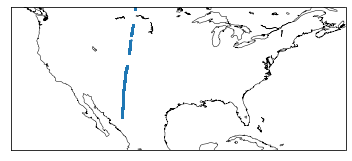

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

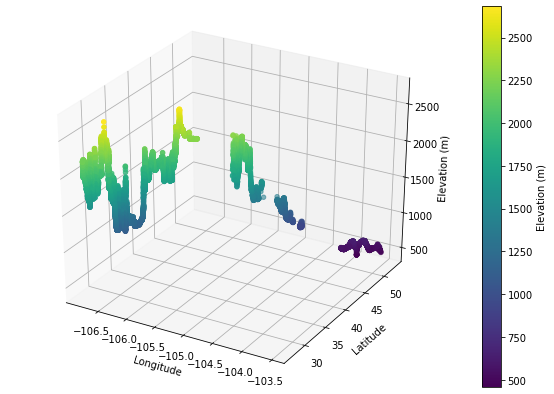

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

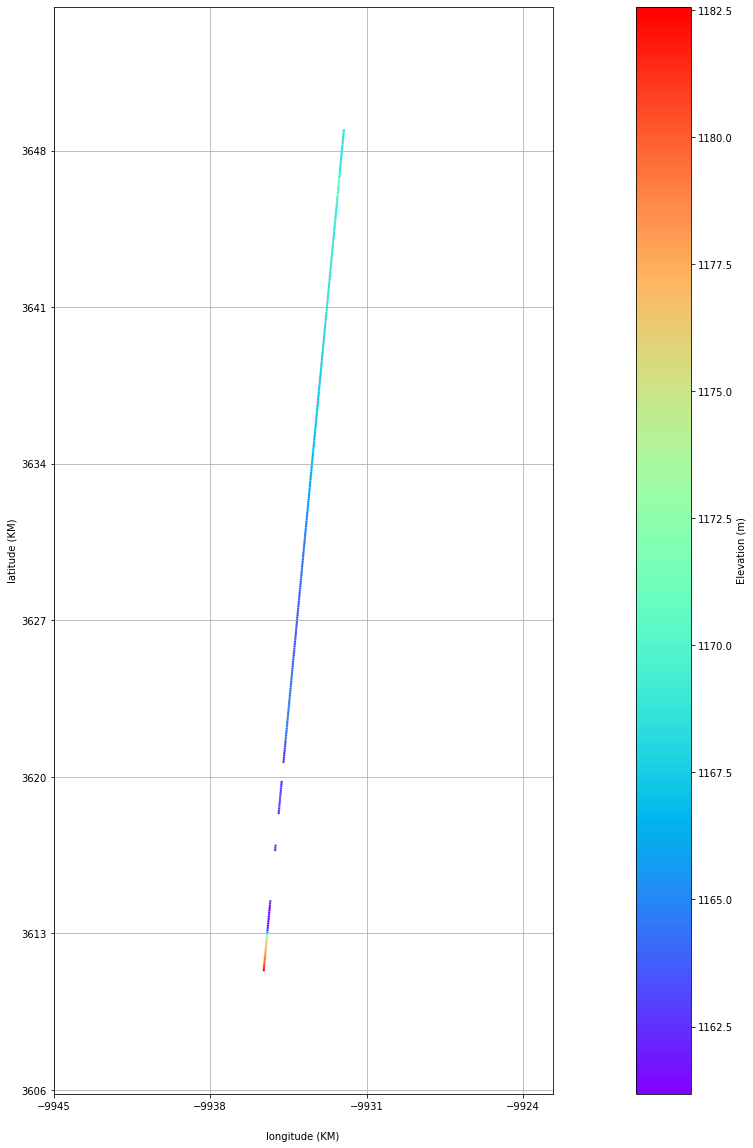

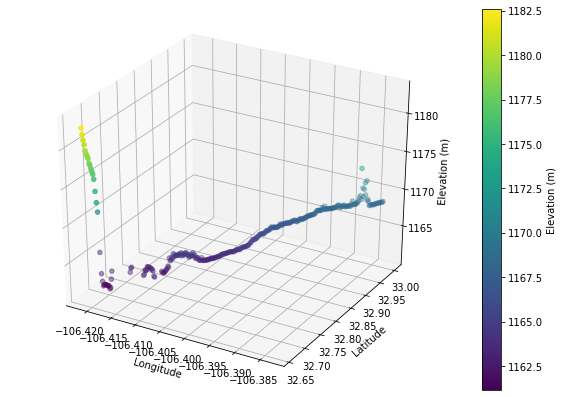

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

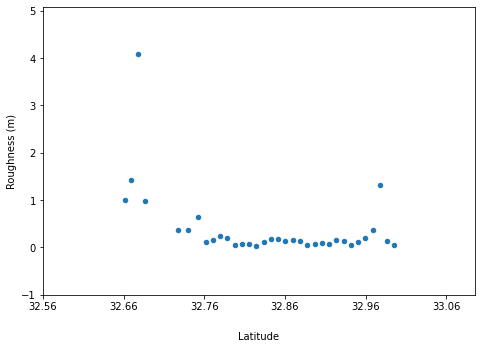

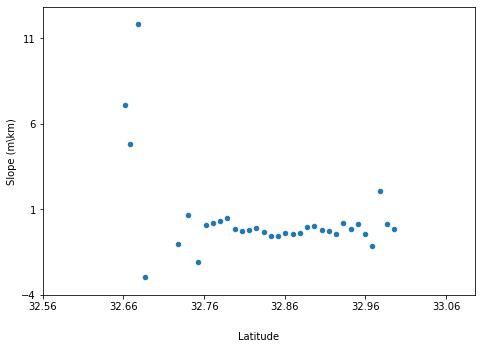

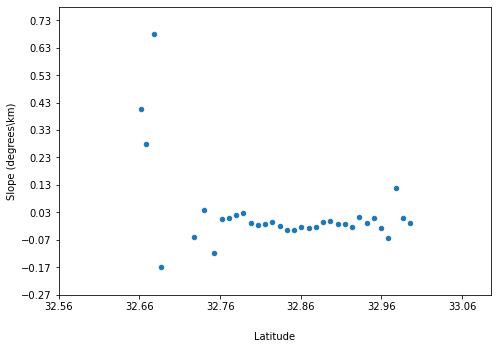

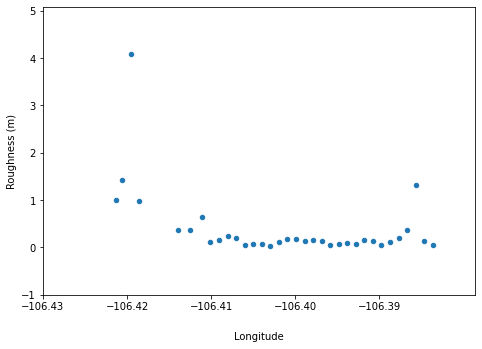

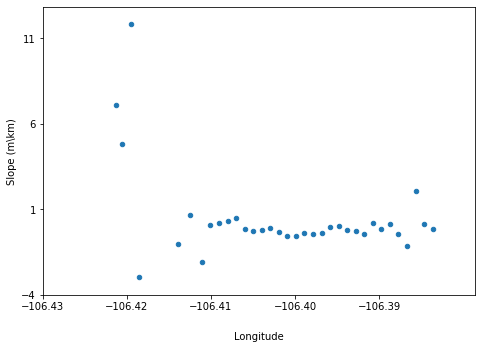

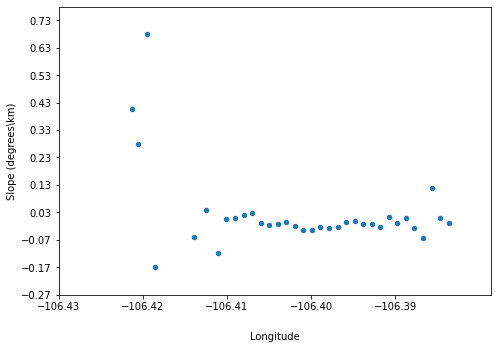

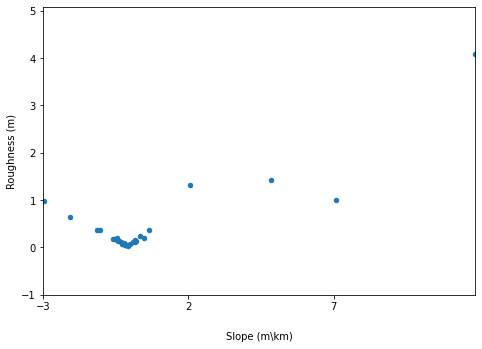

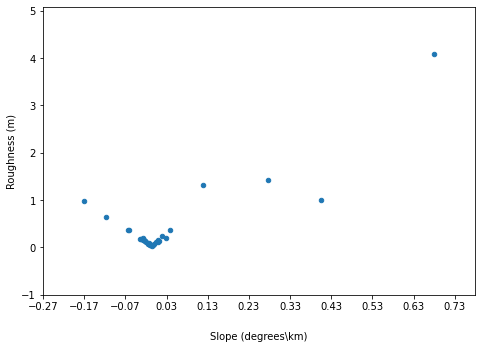

In [45]:
laserPlots(data_path,'gt1l')

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

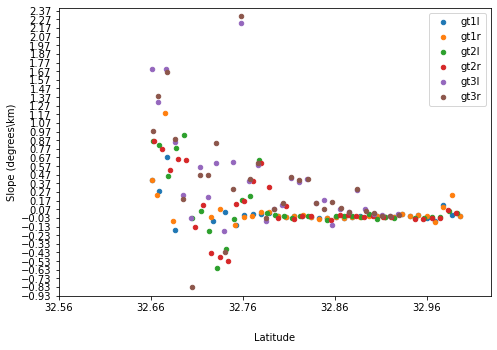

In [35]:
overlapPlots(data_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

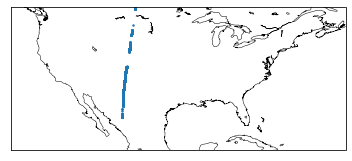

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

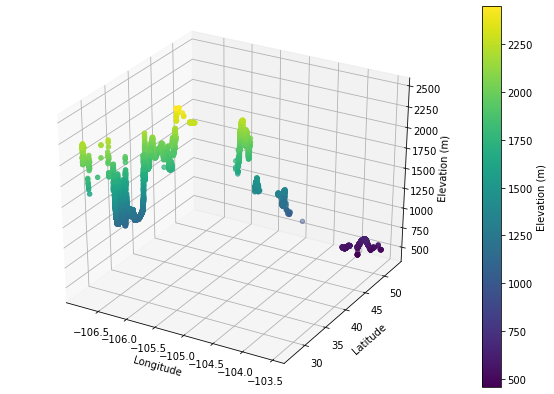

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

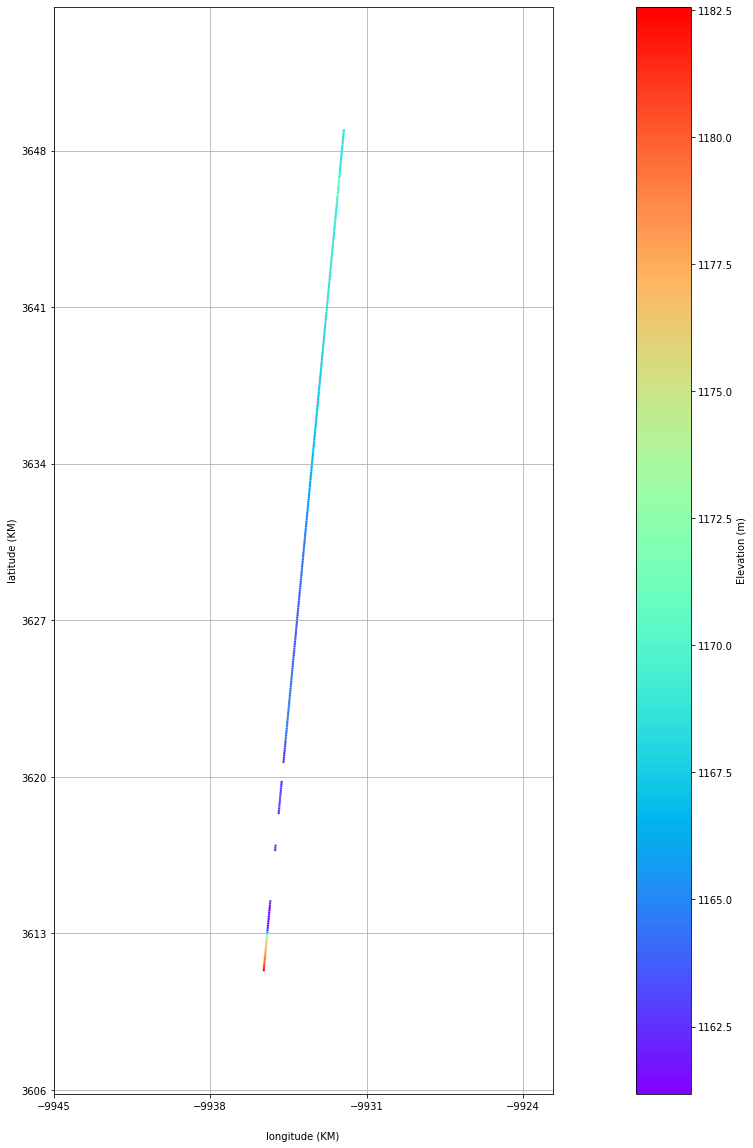

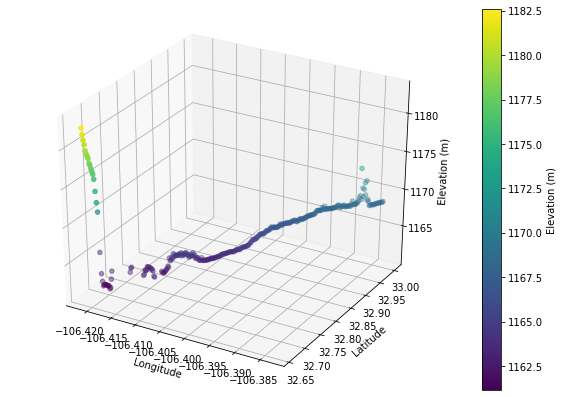

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

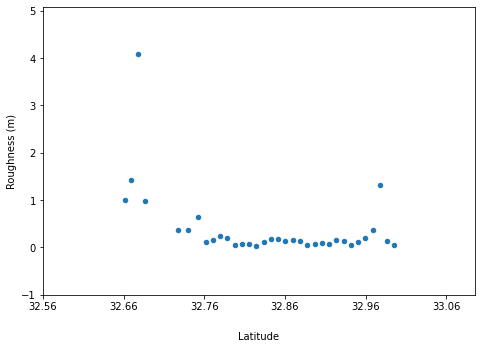

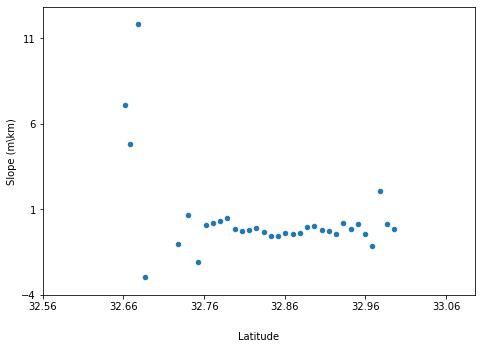

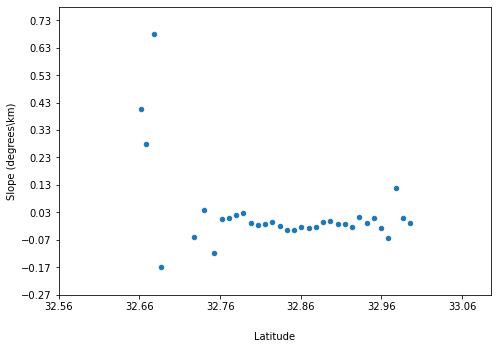

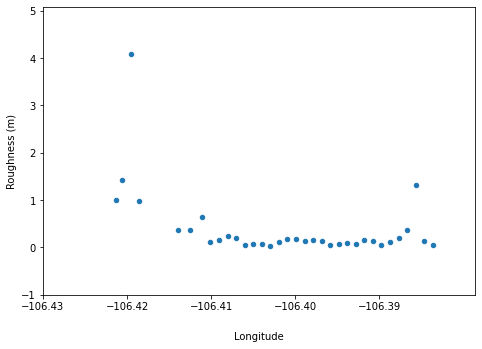

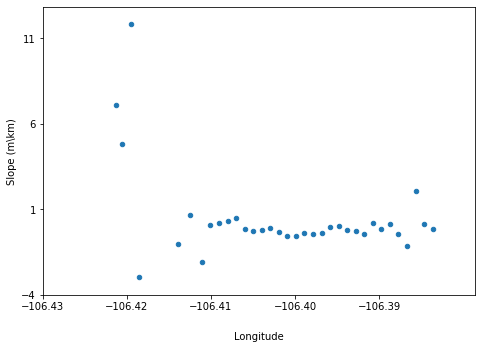

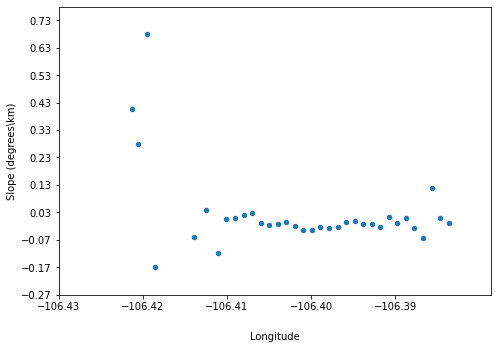

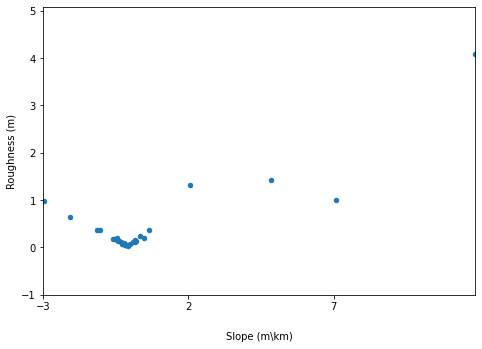

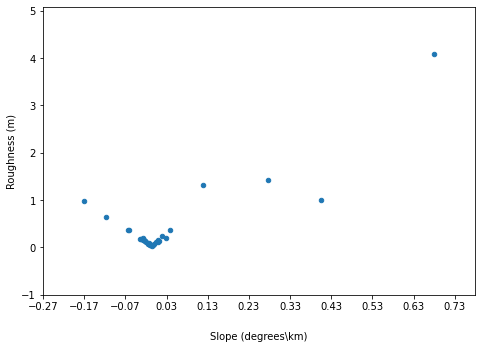

In [46]:
laserPlots(data_path,'gt1r')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

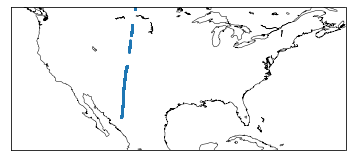

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

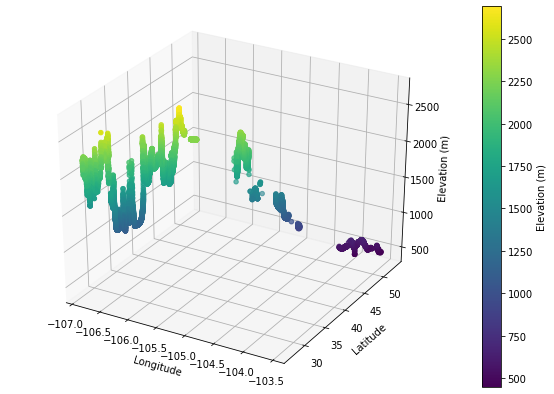

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

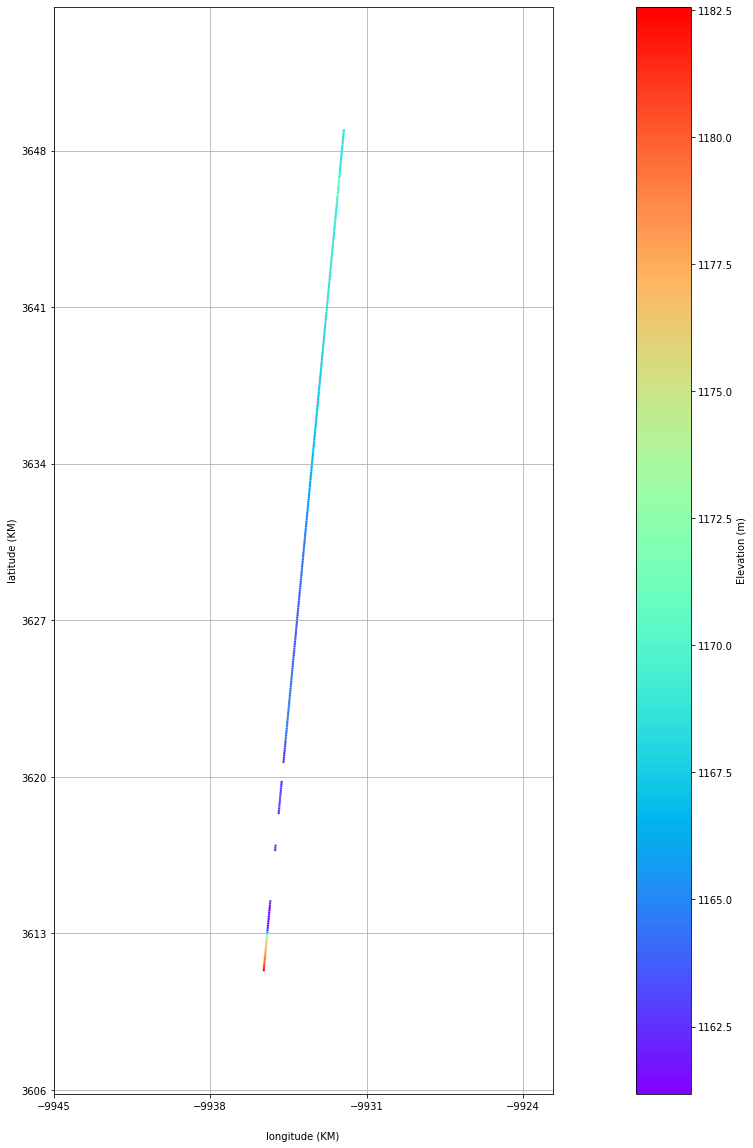

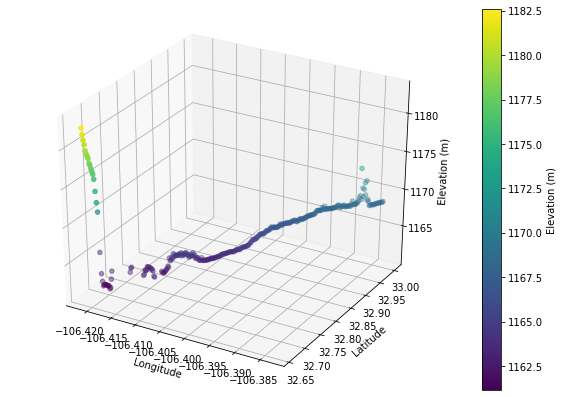

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

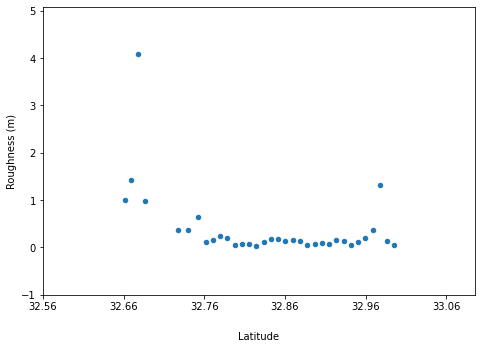

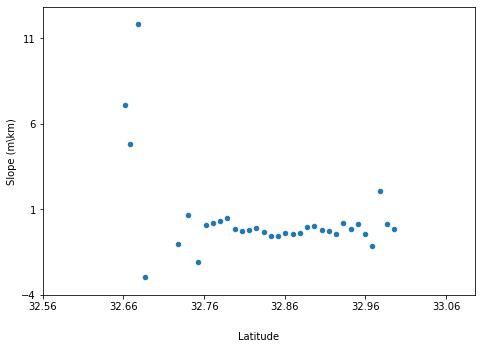

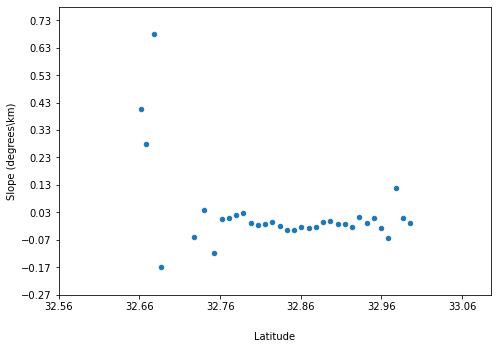

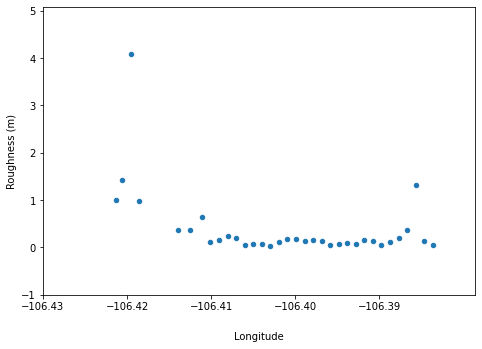

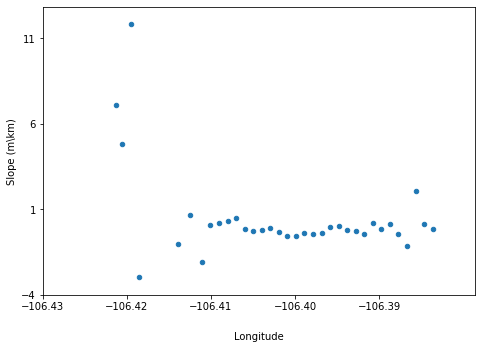

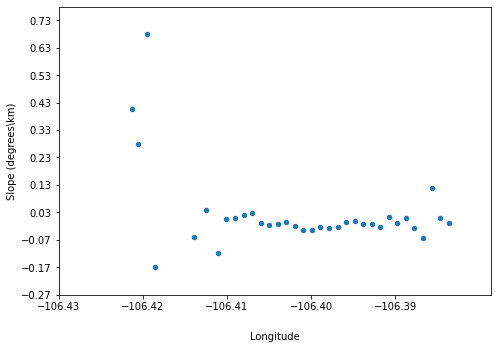

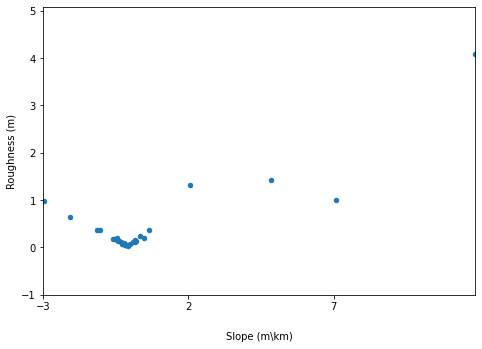

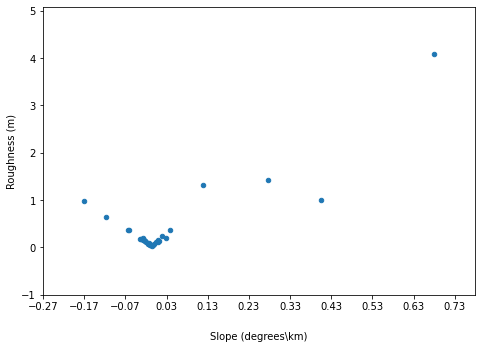

In [47]:
laserPlots(data_path,'gt2l')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

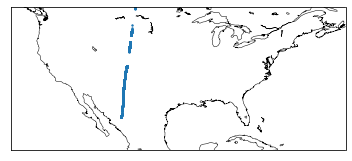

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

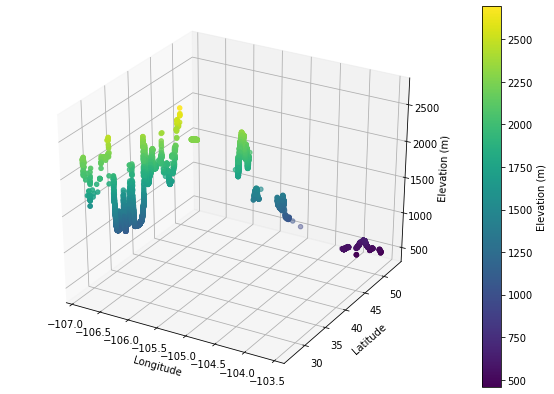

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

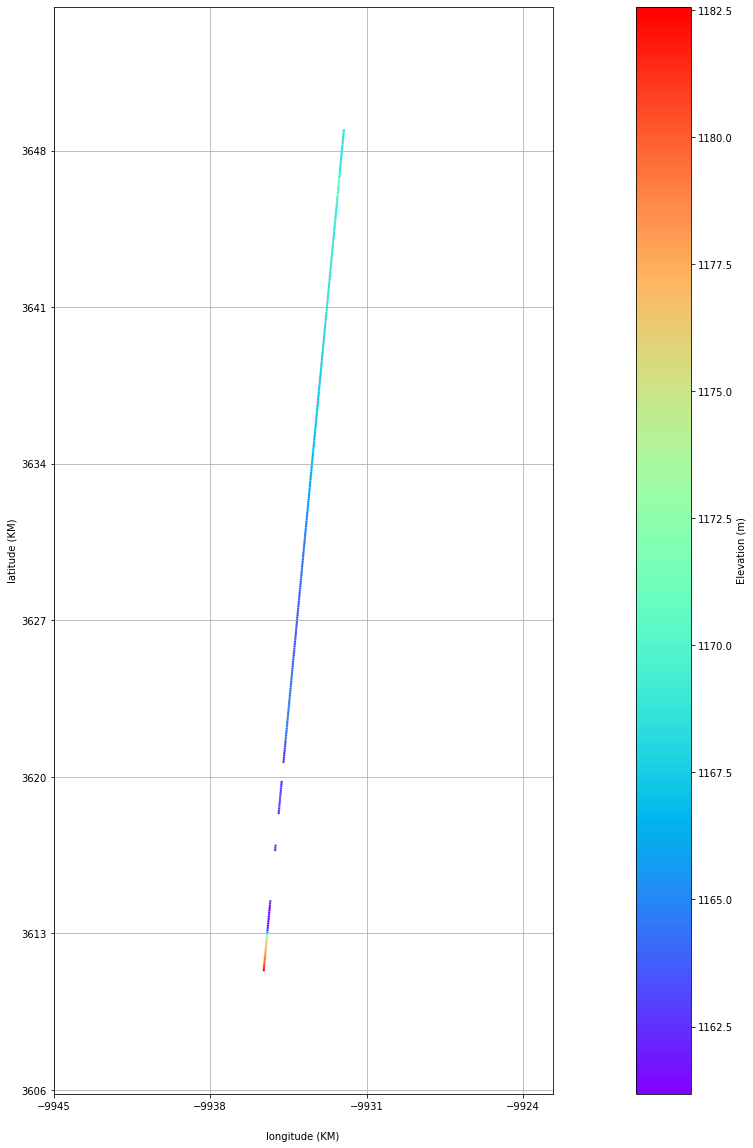

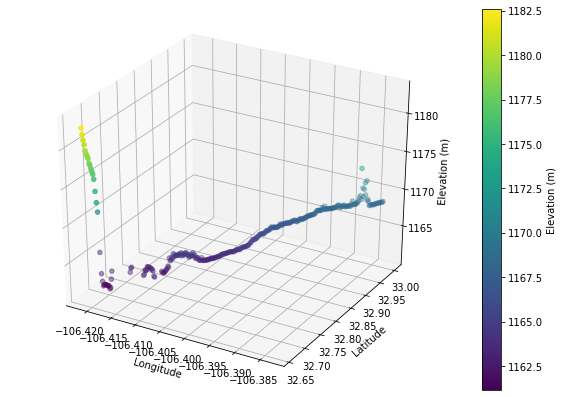

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

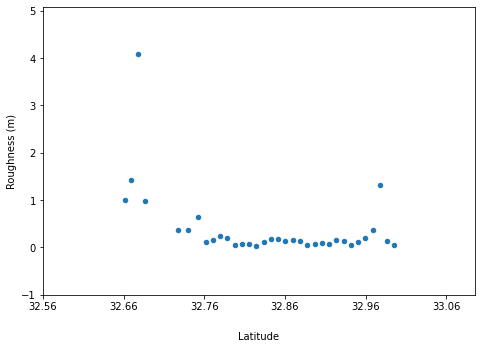

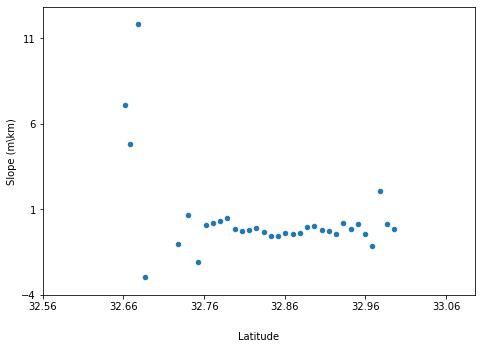

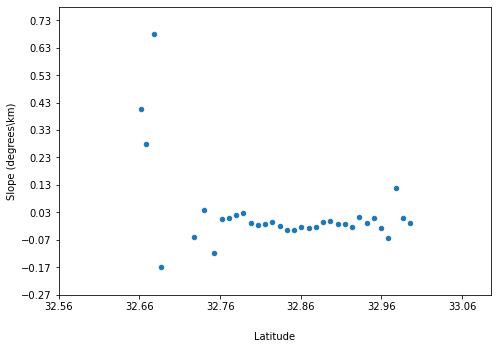

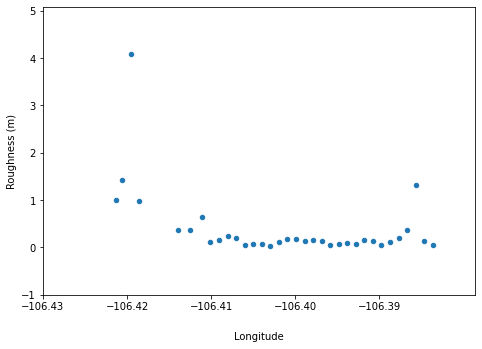

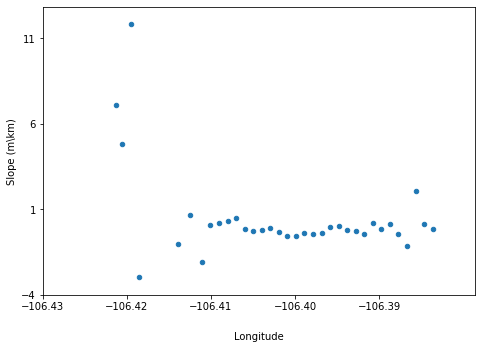

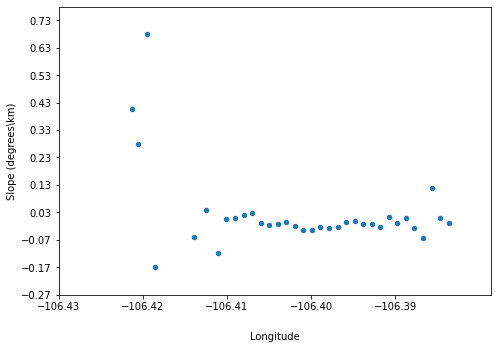

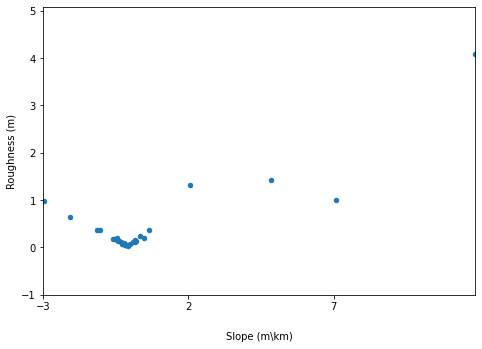

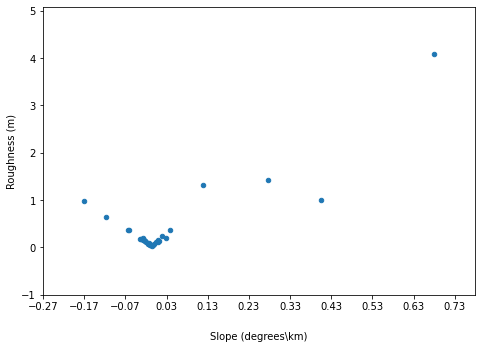

In [48]:
laserPlots(data_path,'gt2r')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

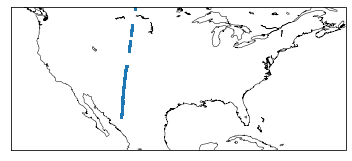

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

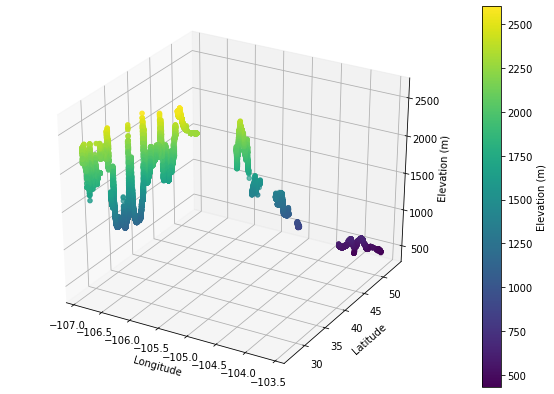

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

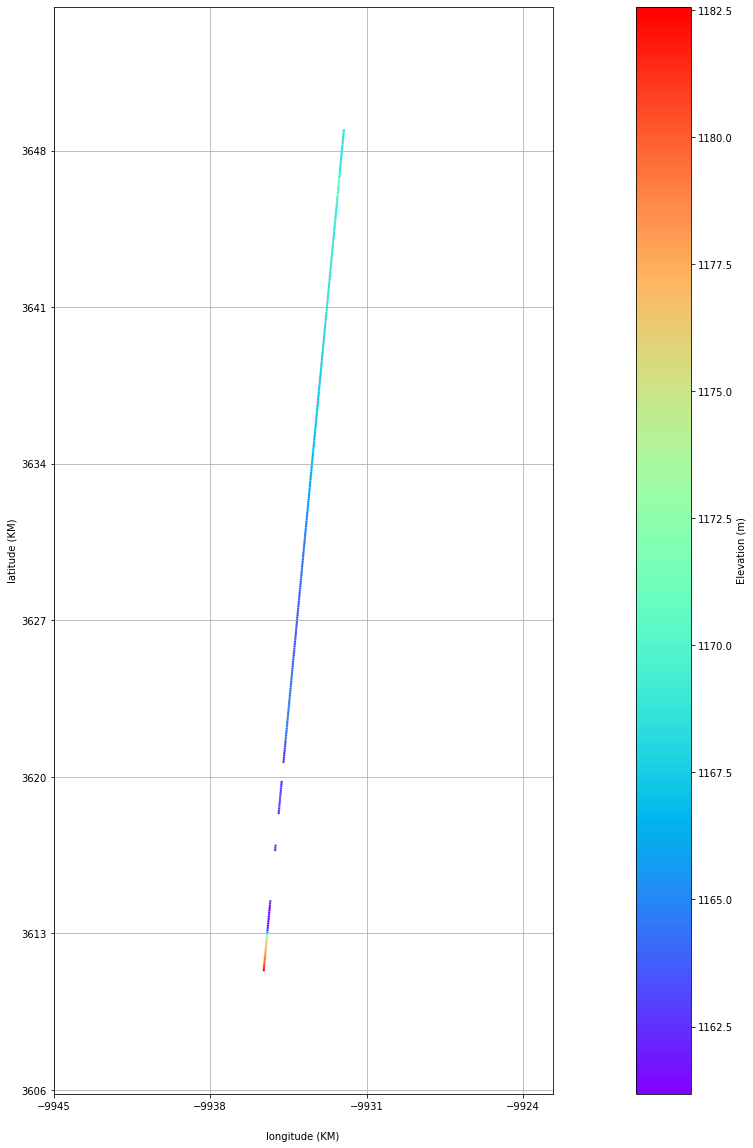

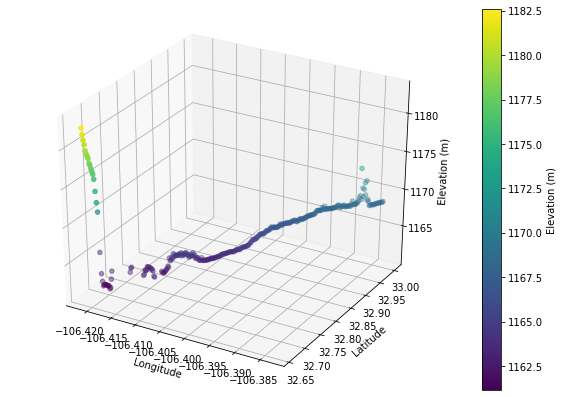

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

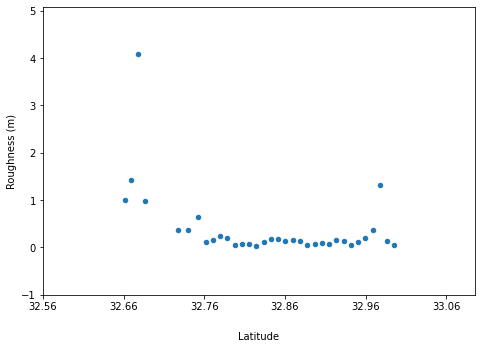

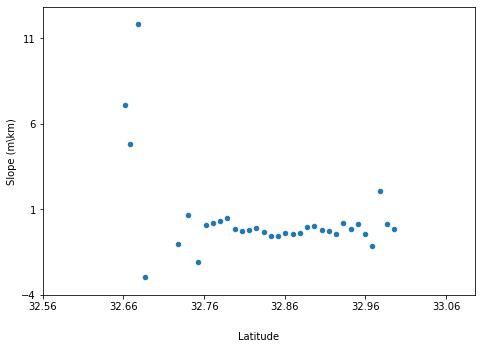

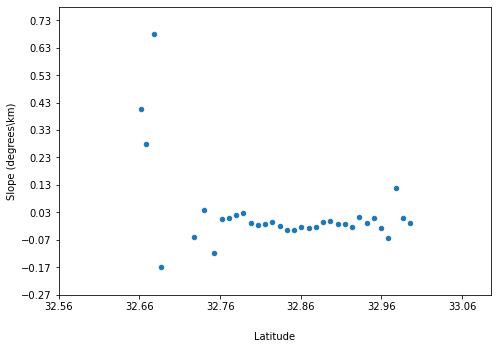

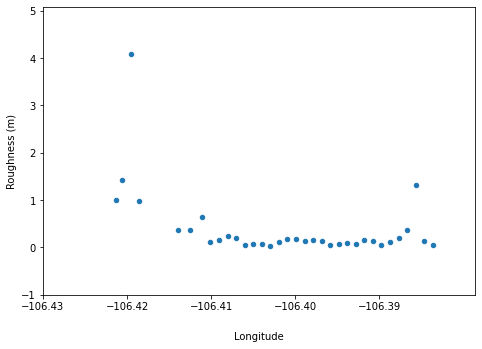

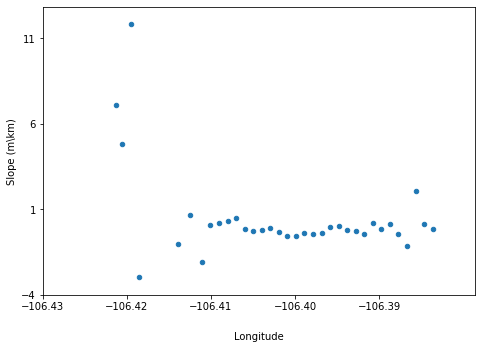

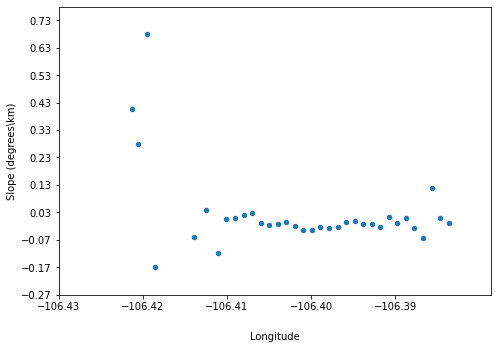

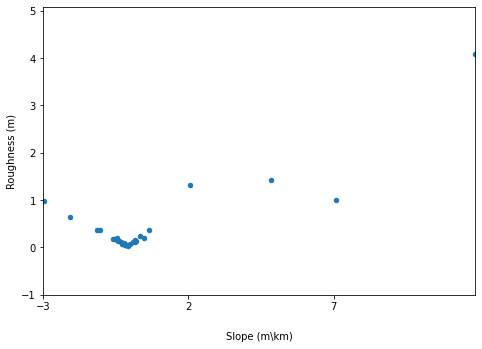

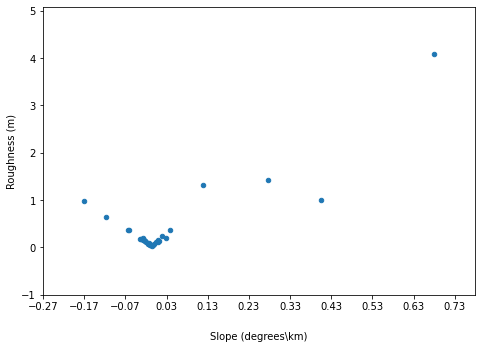

In [49]:
laserPlots(data_path,'gt3l')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

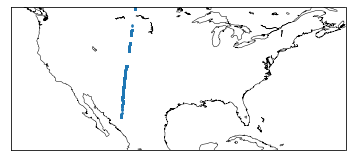

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

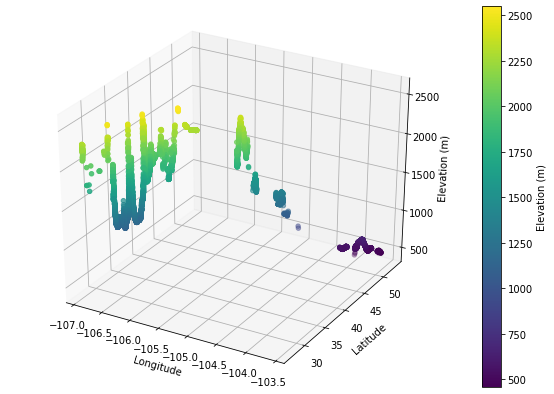

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

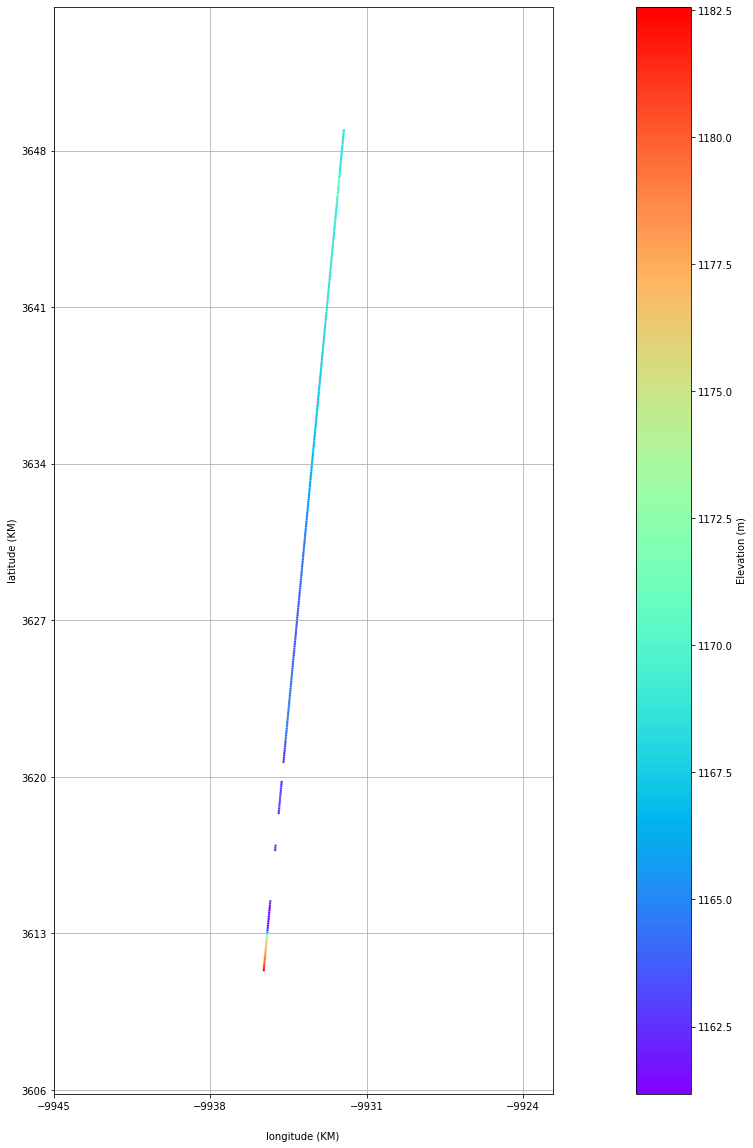

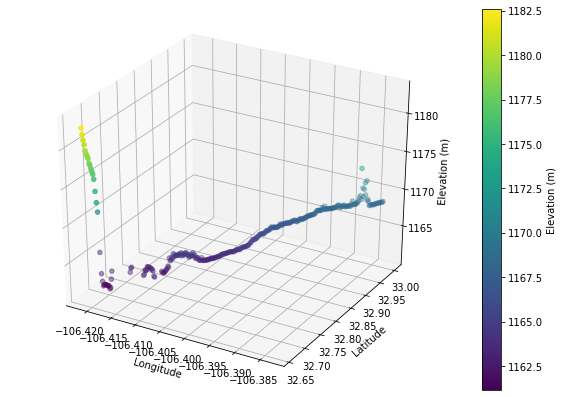

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

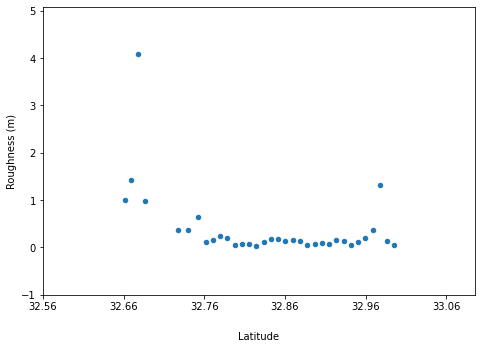

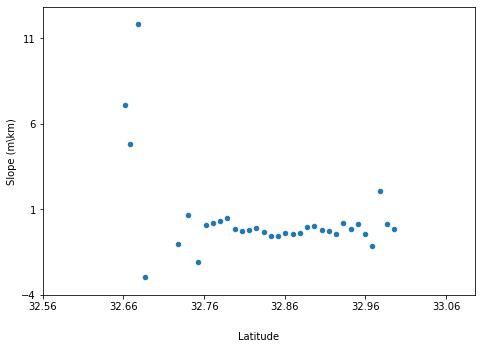

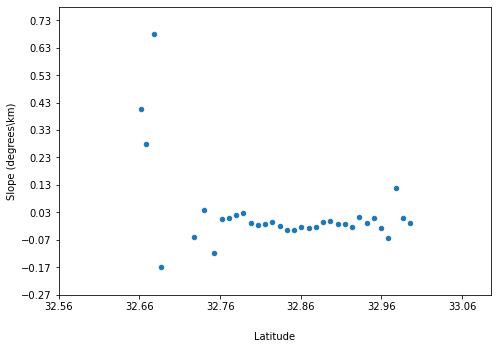

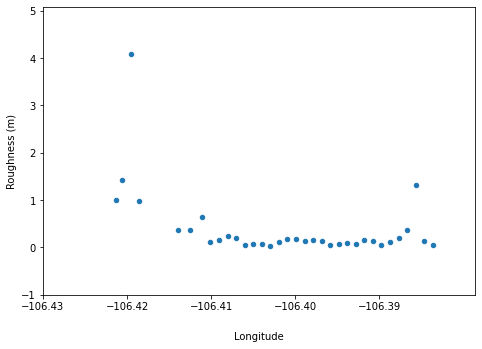

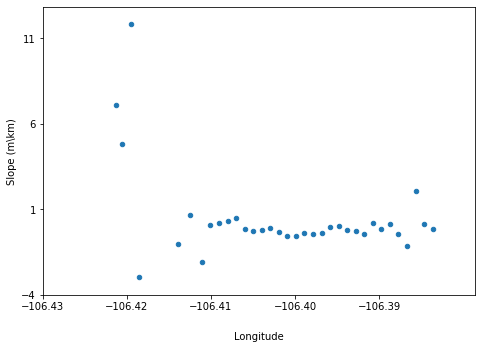

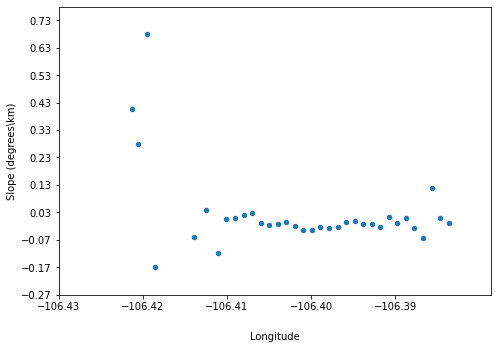

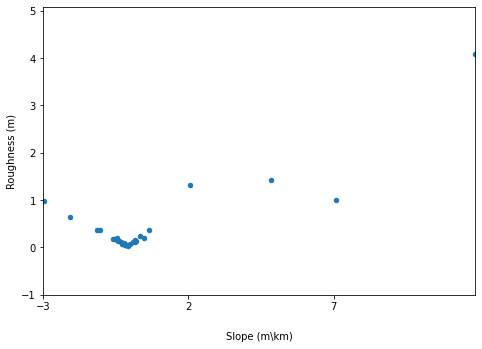

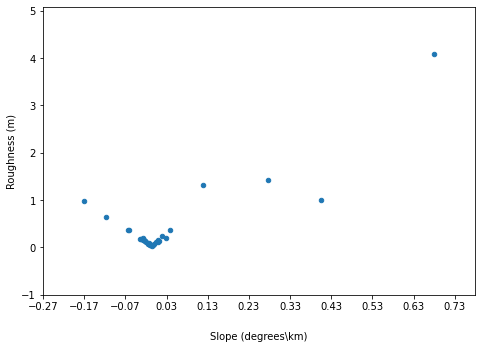

In [50]:
laserPlots(data_path,'gt3r')

In [ ]:
#Not used
tmp_A = []
tmp_b = []
for i in range(len(kmlat)):
    tmp_A.append([Average(kmlon[i]), Average(kmlat[i]), 1])
    tmp_b.append(Average(kmelev[i]))
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)
fit = (A.T * A).I * A.T * b
errors = b - A * fit
residual = np.linalg.norm(errors)

# plot plane
plt.figure()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
X,Y = np.meshgrid(np.arange(xlim[0], xlim[1]),
                  np.arange(ylim[0], ylim[1]))

Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fit[0] * X[r,c] + fit[1] * Y[r,c] + fit[2]
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X,Y,Z, color='k')


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()


In [ ]:
#Not Used
kmlat = []
kmlon = []
standarddev = []

count = 0
calc = []
total = 0
for i in range(len(newlat)):
  if(count < 10):
    calc.append(newlat[i])
    total += newlat[i]
    
  if(count == 9):
    kmlat.append(total/10)
    standarddev.append(np.std(calc))
    count = -1
    total = 0
    calc.clear()
  
  count+=1

  if(i == len(newlat)-1):
    kmlat.append(total/(len(newlat)%10))
    standarddev.append(np.std(calc))
  
print(kmlat)